# Dataset: NIH Chest X ray-14 (224 x 224,Disease wise folder)
#### Link: https://www.kaggle.com/khanfashee/nih224folderwise-data

In [44]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import cv2
import imghdr
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.metrics import Accuracy

The get_train_val function is designed to create and configure ImageDataGenerators for training and validation data. These generators are essential components when working with large datasets, enabling real-time data augmentation and efficient batch processing during model training.

Parameters:
train_path: The path to the directory containing the training images.

val_path: The path to the directory containing the validation images.

ImageDataGenerators:
Training Data Generator (train_datagen):

rescale=1./255: Normalizes pixel values to the range [0, 1].
shear_range=0.2: Applies random shear transformations to augment the data.
zoom_range=0.2: Applies random zoom transformations for further data augmentation.
horizontal_flip=True: Randomly flips images horizontally, introducing diversity to the training set.
fill_mode='nearest': Specifies the method used for filling in newly created pixels resulting from transformations.
Validation Data Generator (val_datagen):

rescale=1./255: Normalizes pixel values to the range [0, 1].

 Flow from Directory:
Training Data Generator (train_generator):

Flows training images in batches from the specified directory.
Flows validation images in batches from the specified directory.



In [4]:
def get_train_val(train_path, val_path):
    # ImageDataGenerator for training data with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # ImageDataGenerator for validation data
    val_datagen = ImageDataGenerator(rescale=1./255)

    # Flow training images in batches using train_datagen
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        class_mode='categorical'
    )

    # Flow validation images in batches using val_datagen
    val_generator = val_datagen.flow_from_directory(
        val_path,
        target_size=(224, 224),
        class_mode='categorical'
    )


    
    return train_generator, val_generator
    
    

### Training model with 200 train images and 27 images for validation.

In [5]:
train1 = tf.keras.utils.image_dataset_from_directory('data_300_80_100/train', labels='inferred', 
                                                   label_mode='categorical',
                                                   image_size=(224, 224))


val1 = tf.keras.utils.image_dataset_from_directory('data_300_80_100/val', labels='inferred', 
                                                   label_mode='categorical', 
                                                   image_size=(224, 224))


Found 1500 files belonging to 5 classes.
Found 400 files belonging to 5 classes.


In [6]:
train1_iterator = train1.as_numpy_iterator()
batch = train1_iterator.next()

C:\Users\makbar\Anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


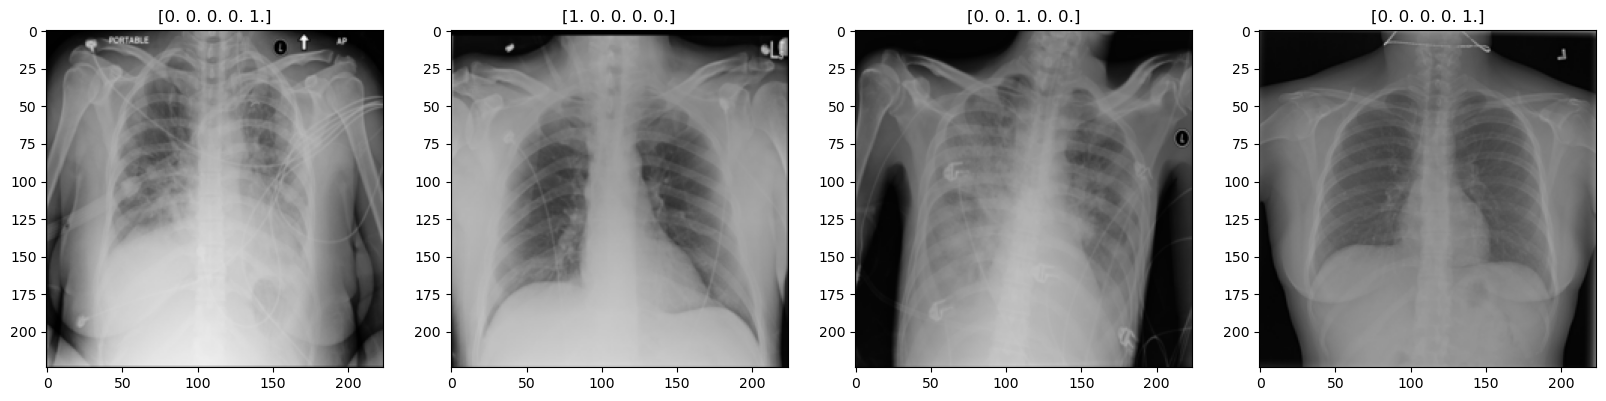

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int), cmap='gray', vmin=0, vmax=255)
    ax[idx].title.set_text(batch[1][idx])

In [8]:
# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train1 = train1.map(process)
val1 = val1.map(process)

## Model Architecture (1) with 300 train images and 80 validation images:

The model architecture is a Convolutional Neural Network (CNN) which is mainly used for image classification. Here, we are training model without any image augmentation to see how the model performs.
It consists of two convolutional layers with max-pooling, followed by a flattening layer and two fully connected layers. The model uses ReLU activation for non-linearity, dropout for regularization, and softmax activation for multi-class classification. The Adam optimizer is employed with categorical crossentropy as the loss function, and the model is compiled to optimize accuracy during training.

In [9]:
# Model Architecture
model = Sequential()


model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax')) 

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 256)               4

In [44]:
# early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
# history = model.fit(train, epochs=30, validation_data=val, callbacks=[early_stopping])

In [11]:
# Model training
history = model.fit(train1, epochs=100, validation_data=val1)

Epoch 1/100
47/47 [==============================] - 174s 4s/step - loss: 2.1779 - accuracy: 0.2140 - val_loss: 1.6090 - val_accuracy: 0.2100
Epoch 2/100
47/47 [==============================] - 170s 4s/step - loss: 1.5713 - accuracy: 0.2647 - val_loss: 1.6951 - val_accuracy: 0.2000
Epoch 3/100
47/47 [==============================] - 161s 3s/step - loss: 1.4319 - accuracy: 0.3927 - val_loss: 1.7637 - val_accuracy: 0.2550
Epoch 4/100
47/47 [==============================] - 165s 4s/step - loss: 1.2111 - accuracy: 0.5167 - val_loss: 1.9080 - val_accuracy: 0.2525
Epoch 5/100
47/47 [==============================] - 165s 4s/step - loss: 0.9081 - accuracy: 0.6540 - val_loss: 2.1489 - val_accuracy: 0.2450
Epoch 6/100
47/47 [==============================] - 165s 3s/step - loss: 0.6240 - accuracy: 0.7760 - val_loss: 2.5045 - val_accuracy: 0.2375
Epoch 7/100
47/47 [==============================] - 163s 3s/step - loss: 0.4260 - accuracy: 0.8687 - val_loss: 2.7856 - val_accuracy: 0.2200
Epoch 

## Model Evaluation:
As we can see from the training results and graphs below, the model is clearly overfitting, performing really good on training data but fails to perform on validation data.

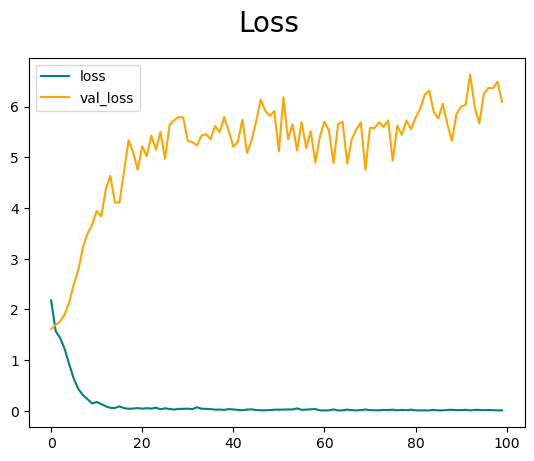

In [12]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

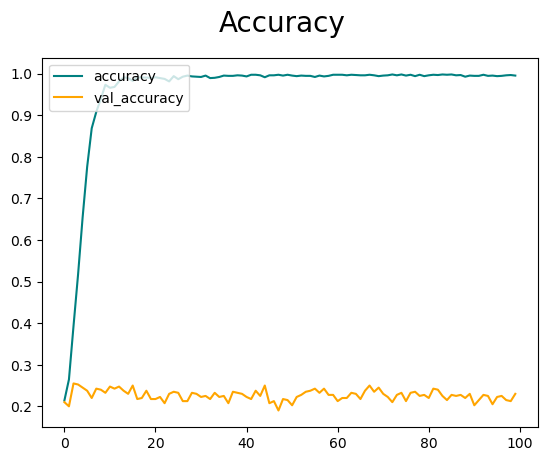

In [13]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [15]:
# Evaluate the model on test set
test_dir = 'data_300_80_100/test'

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow test images in batches using test_datagen
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    class_mode='categorical'
)

test_loss, test_accuracy = model.evaluate_generator(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Found 500 images belonging to 5 classes.


C:\Users\makbar\AppData\Local\Temp\ipykernel_22688\3493034954.py:13: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_generator)


Test Loss: 6.068927764892578
Test Accuracy: 0.25


The model did not perform well, and is clearly underfitting in this case, hence, we will do cross validation with more epochs to see if there is an improvement. The cross validation for this architecture and data will be done in the last section of this notebook.

## Model Architecture (2) with 300 train images, 80 validation images and 100 test images:

In [105]:
# Importing new data
train, val = get_train_val('data_300_80_100/train', 'data_300_80_100/val')

Found 7000 images belonging to 14 classes.
Found 2100 images belonging to 14 classes.


In [107]:
print("Class Indices (Train):", train.class_indices)
print("Class Indices (Validation):", val.class_indices)

Class Indices (Train): {'Atelectasis': 0, 'Cardiomegaly': 1, 'Consolidation': 2, 'Edema': 3, 'Effusion': 4, 'Emphysema': 5, 'Fibrosis': 6, 'Infiltration': 7, 'Mass': 8, 'No Finding': 9, 'Nodule': 10, 'Pleural': 11, 'Pneumonia': 12, 'Pneumothorax': 13}
Class Indices (Validation): {'Atelectasis': 0, 'Cardiomegaly': 1, 'Consolidation': 2, 'Edema': 3, 'Effusion': 4, 'Emphysema': 5, 'Fibrosis': 6, 'Infiltration': 7, 'Mass': 8, 'No Finding': 9, 'Nodule': 10, 'Pleural': 11, 'Pneumonia': 12, 'Pneumothorax': 13}


### Model (2) Architecture:
The model consists of two convolutional layers with ReLU activation, each followed by max-pooling to downsample spatial dimensions. The flattened output is fed into a dense layer with 256 neurons and ReLU activation, followed by dropout for regularization. The final layer is a dense layer with 14 neurons and softmax activation, indicating it's designed for a multi-class classification task with 14 output classes. The model is compiled using the Adam optimizer, categorical crossentropy loss, and accuracy as the evaluation metric.

Here, we are training model with different layers and parameters, and also using image augmenation to see if it performs well.

In [108]:
# Model Architecture
model = Sequential()


model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(14, activation='softmax')) 

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_19 (Flatten)        (None, 186624)            0         
                                                                 
 dense_38 (Dense)            (None, 256)             

### Model training:
Model training took alot of time, for several hours to compelte 30 epochs.

In [110]:
history_2 = model.fit(train, epochs=30, validation_data=val)

Epoch 1/30
219/219 [==============================] - 600s 3s/step - loss: 2.6404 - accuracy: 0.0691 - val_loss: 2.6390 - val_accuracy: 0.0714
Epoch 2/30
219/219 [==============================] - 569s 3s/step - loss: 2.6396 - accuracy: 0.0677 - val_loss: 2.6392 - val_accuracy: 0.0781
Epoch 3/30
219/219 [==============================] - 610s 3s/step - loss: 2.6380 - accuracy: 0.0720 - val_loss: 2.6385 - val_accuracy: 0.0790
Epoch 4/30
219/219 [==============================] - 626s 3s/step - loss: 2.6383 - accuracy: 0.0806 - val_loss: 2.6377 - val_accuracy: 0.0805
Epoch 5/30
219/219 [==============================] - 583s 3s/step - loss: 2.6394 - accuracy: 0.0743 - val_loss: 2.6369 - val_accuracy: 0.0800
Epoch 6/30
219/219 [==============================] - 567s 3s/step - loss: 2.6379 - accuracy: 0.0787 - val_loss: 2.6360 - val_accuracy: 0.0781
Epoch 7/30
219/219 [==============================] - 556s 3s/step - loss: 2.6352 - accuracy: 0.0791 - val_loss: 2.6374 - val_accuracy: 0.0729

### Model Evaluation:
The model took nearly 5-6 hours to train, and a we cann see, this time the model is not overfitting, but the results are not good as well. As we can see that results are improving slowly at every epoch, and may need more epochs and alot of computation time and resources to give a promising result. Due to computation time and resource scarcity, the model has only been trained upto 30 epochs.

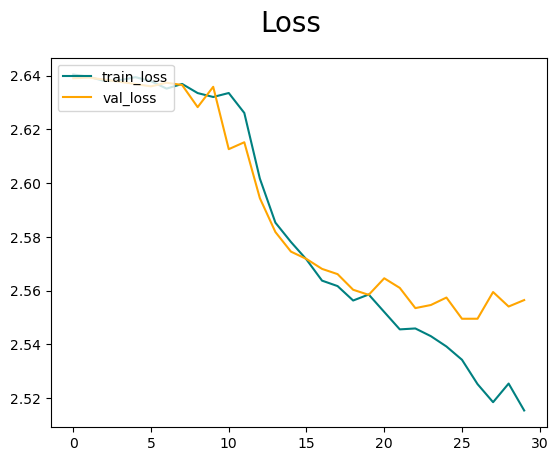

In [117]:
fig = plt.figure()
plt.plot(history_2.history['loss'], color='teal', label='train_loss')
plt.plot(history_2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

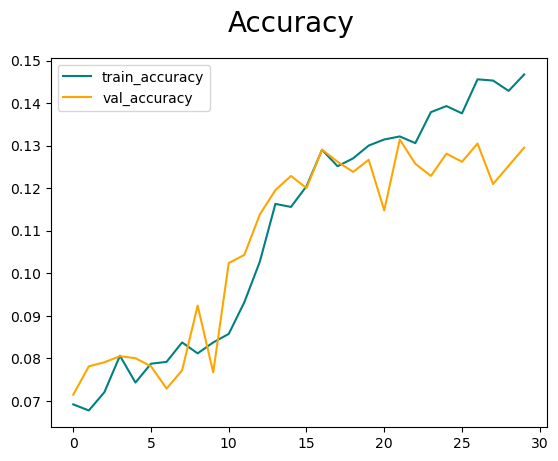

In [118]:
fig = plt.figure()
plt.plot(history_2.history['accuracy'], color='teal', label='train_accuracy')
plt.plot(history_2.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Testing model on Test data

In [115]:
test_dir = 'data_300_80_100/test'

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow test images in batches using test_datagen
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical'
)

test_loss, test_accuracy = model.evaluate_generator(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Found 2800 images belonging to 14 classes.


C:\Users\makbar\AppData\Local\Temp\ipykernel_17488\771361953.py:13: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_generator)


Test Loss: 2.5287206172943115
Test Accuracy: 0.1542857140302658


# Cross Validation

In [31]:
model3 = model
k = 3
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Convert datasets to numpy arrays
train_images = []
train_labels = []

for image, label in train1:
    train_images.append(image)
    train_labels.append(label)

train_images = tf.concat(train_images, axis=0)
train_labels = tf.concat(train_labels, axis=0)

train_images_np = train_images.numpy()
train_labels_np = train_labels.numpy()

fold_accuracies = []

for train_index, val_index in kf.split(train_images_np):
    train_fold_images, val_fold_images = train_images_np[train_index], train_images_np[val_index]
    train_fold_labels, val_fold_labels = train_labels_np[train_index], train_labels_np[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model on the current fold's training data with early stopping
    history = model3.fit(
        x=train_fold_images, y=train_fold_labels, 
        epochs=30, 
        validation_data=(val_fold_images, val_fold_labels),
        callbacks=[early_stopping]
    )

    # Evaluate the model on the current fold's validation data and store the accuracy
    _, val_accuracy = model3.evaluate(x=val_fold_images, y=val_fold_labels)
    fold_accuracies.append(val_accuracy)

average_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print("Average accuracy across all folds:", average_accuracy)


Epoch 1/30
32/32 [==============================] - 73s 2s/step - loss: 0.0027 - accuracy: 0.9990 - val_loss: 0.0160 - val_accuracy: 0.9933
Epoch 2/30
32/32 [==============================] - 64s 2s/step - loss: 0.0027 - accuracy: 0.9990 - val_loss: 0.0169 - val_accuracy: 0.9933
Epoch 3/30
32/32 [==============================] - 64s 2s/step - loss: 0.0046 - accuracy: 0.9990 - val_loss: 0.0171 - val_accuracy: 0.9933
Epoch 4/30
16/16 [==============================] - 7s 408ms/step - loss: 0.0095 - accuracy: 0.9960
Epoch 1/30
32/32 [==============================] - 71s 2s/step - loss: 0.0085 - accuracy: 0.9970 - val_loss: 0.0030 - val_accuracy: 0.9980
Epoch 2/30
32/32 [==============================] - 69s 2s/step - loss: 0.0072 - accuracy: 0.9960 - val_loss: 0.0031 - val_accuracy: 0.9980
Epoch 3/30
32/32 [==============================] - 65s 2s/step - loss: 0.0085 - accuracy: 0.9970 - val_loss: 0.0042 - val_accuracy: 0.9980
Epoch 4/30
16/16 [==============================] - 6s 352ms

In [41]:
cross_val_df = pd.DataFrame({'Fold': [1,2,3],
                            'Accuracy': fold_accuracies})

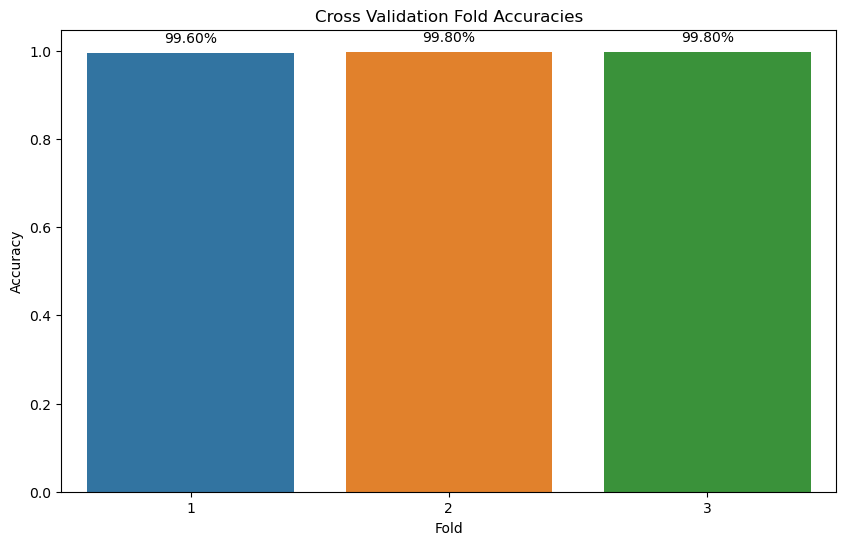

In [56]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x='Fold', y='Accuracy', data=cross_val_df)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.title("Cross Validation Fold Accuracies")
plt.show()